# DIS background removal tool on Inference Amazon SageMaker

In this notebook, we will implement asynchronous inferencing using the [DIS background removal tool](https://github.com/xuebinqin/DIS) in Amazon SageMaker. By using [Amazon SageMaker Asynchronous inference](https://docs.aws.amazon.com/sagemaker/latest/dg/async-inference.html), you can process a large batch of images at scale with large payload sizes (up to 1GB) with near real-time latency. 

We will walkthrough on how to package a pre-train DIS model, implement the inferencing with a custom inference script and deploy out asynchronous endpoint.

**High Level Steps**
1. Package inference script, model and pre-train weights
2. Create SNS topics (optional) to record succcess/error messages from asynchronous inference
3. Create asynchronous configuration and deploy endpoint
4. Run Inference


In [ ]:
# Install python dependencies
!pip install gdown

In [ ]:
import os, gdown
import boto3
import sagemaker
from sagemaker.pytorch import PyTorch, PyTorchModel
import time
from time import gmtime, strftime
from datetime import datetime
import urllib
import numpy as np
import sys
import matplotlib.pyplot as plt
import json
from PIL import Image

%matplotlib inline

In [ ]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()  ### Replace with your own bucket if needed
role = sagemaker.get_execution_role(sagemaker_session)
prefix = "dis-background-removal"  ### Replace with the S3 prefix desired
region = boto3.Session().region_name
boto_session = boto3.session.Session()
sm_client = boto_session.client("sagemaker")
sm_runtime = boto_session.client("sagemaker-runtime")
sns_client = boto3.client('sns')
print(f"S3 bucket: {bucket}")
print(f"Role: {role}")
print(f"Region: {region}")

## 1. Prepare package - Pre-train weights, model and code

In this section, we will:
    
1. Download the official pre-train weights
2. Download the DIS model from the git repository (https://github.com/xuebinqin/DIS)
3. Prepare our inference script
4. Package our model, weights and script
5. Upload package to S3


Anatomy of our package folder
- `model.pth` - Our pre-train model weights
- `/code/inference_script.py` - Our SageMaker inference script to be used. This overrides the default pytorch inferencing functionality with our own implementation.
- `/code/requirements.txt` - Inference script dependencies
- `/code/models` Folder containing the DIS model

In [ ]:
# Define our model directory
model_artifact= os.path.join("s3://", bucket, prefix, "model.tar.gz")
model_artifact

### 1.1 Download official pre-train weight

In [ ]:
# Download official weights
if not os.path.exists("saved_models"):
    os.mkdir("saved_models")
    MODEL_PATH_URL = "https://drive.google.com/uc?id=1KyMpRjewZdyYfxHPYcd-ZbanIXtin0Sn"
    gdown.download(MODEL_PATH_URL, "saved_models/model.pth", use_cookies=False)

### 1.2 Download DIS model

In [ ]:
!mkdir model_and_code
!cp ./saved_models/model.pth ./model_and_code
!mkdir model_and_code/code

In [ ]:
!git clone https://github.com/xuebinqin/DIS

#### Copy the model to the package folder

In [ ]:
!mv DIS/IS-Net/* ./model_and_code/code
!rm ./model_and_code/code/Inference.py
!rm ./model_and_code/code/requirements.txt

### 1.3 Prepare infererncing script

As we will be using a custom pytoch model and mechanism for loading our data, we will need to implement custom functions for processing loading the model, processing the input, prediction and output. In this section, we will prepare and package our inferencing script (`./scripts/inference.py`). Let's have a look at the inference script below.

How to implement a custom inference script: https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#serve-a-pytorch-model

In [ ]:
!pygmentize ./scripts/inference.py

#### Copy inference script to packaging folder

In [ ]:
!cp -r ./scripts/* model_and_code/code

### 1.4 Package code and model into model.tar.gz

In [ ]:
!tar cvzf model.tar.gz -C model_and_code/ . 

### 1.5 Upload model and code to S3

In [ ]:
!aws s3 cp model.tar.gz $model_artifact

## 2. Create async endpoint

In this section we will walkthrough how to create an Amazon SageMaker Asynchronous endpoint. As part of the configuration, we will also create a SNS topic to capture the success and error events when invoking the asynchronous endpoint.

Reference: https://github.com/aws-samples/amazon-sagemaker-asynchronous-inference-computer-vision/blob/main/mask-rcnn-async-inference.ipynb

### Create SNS Error and Success topics

**Prerequisite**
Make sure IAM role has permission to create sns topics. For more information on required permissions, refer to the following documentation: https://docs.aws.amazon.com/sagemaker/latest/dg/async-inference-create-endpoint-prerequisites.html

In [ ]:
response = sns_client.create_topic(Name=f"{prefix}-Async-ErrorTopic")
error_topic= response['TopicArn']
print(error_topic)

In [ ]:
response = sns_client.create_topic(Name=f"{prefix}-Async-SuccessTopic")
success_topic = response['TopicArn']
print(success_topic)

In [ ]:
response = sns_client.list_topics()
topics = response["Topics"]
print(topics)

### Create SageMaker Model with PyTorch inference conatiner

In [ ]:
# Retrieve inference container
from sagemaker.image_uris import retrieve

deploy_instance_type = 'ml.m5.4xlarge'
pytorch_inference_image_uri = retrieve('pytorch',
                                       region,
                                       version='1.12',
                                       py_version='py38',
                                       instance_type = deploy_instance_type,
                                       accelerator_type=None,
                                       image_scope='inference')
print(pytorch_inference_image_uri)

In [ ]:
container = pytorch_inference_image_uri
model_name = 'sagemaker-maskrcnn-{0}'.format(str(int(time.time())))
print(container)
print(model_name)

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = {
        'Image': container,
        'ModelDataUrl': model_artifact,
        'Environment': {
            'TS_MAX_REQUEST_SIZE': '100000000', #default max request size is 6 Mb for torchserve, need to update it to support the 70 mb input payload
            'TS_MAX_RESPONSE_SIZE': '100000000',
            'TS_DEFAULT_RESPONSE_TIMEOUT': '1000'
        }
    },    
)

### Create Asynchronous inference endpoint

In [ ]:
resource_name = "DISSegmentation-{}-{}"

endpoint_config_name = resource_name.format(
    "EndpointConfig", datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
)
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.m5.4xlarge",
            "InitialInstanceCount": 1,
        }
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            "S3OutputPath": f"s3://{bucket}/{prefix}/output",
            # Optionally specify Amazon SNS topics
            "NotificationConfig": {
              "SuccessTopic": success_topic,
              "ErrorTopic": error_topic,
            }
        },
        "ClientConfig": {"MaxConcurrentInvocationsPerInstance": 4},
    },
)
print(f"Created EndpointConfig: {create_endpoint_config_response['EndpointConfigArn']}")

In [ ]:
endpoint_name = f"sm-{prefix}-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
create_endpoint_response = sm_client.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
print(f"Creating Endpoint: {create_endpoint_response['EndpointArn']}")

In [ ]:
waiter = boto3.client('sagemaker').get_waiter('endpoint_in_service')
print("Waiting for endpoint to create...")
waiter.wait(EndpointName=endpoint_name)
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
print(f"Endpoint Status: {resp['EndpointStatus']}")

## 3. Inference

Now that our endpoint is in service, let us run some inference and retrieve the results.

Note: In our inference script we can configured it to save the raw mask in a json and we will need to convert it into to preview our results as shown below. If you do want to modify how the inference script save your output, you can implement it in the `output_fn()` in the `scripts/inference.py` file.

In [ ]:
def upload_file(input_location, prefix):
    prefix = f"{prefix}/input"
    return sagemaker_session.upload_data(
        input_location, 
        bucket=sagemaker_session.default_bucket(),
        key_prefix=prefix, 
        extra_args={"ContentType": "image/jpg"})

In [ ]:
input_1_location = "data/sample.jpg"
input_1_s3_location = upload_file(input_1_location, prefix)

In [ ]:
print(input_1_s3_location)

In [ ]:
print(endpoint_name)

### Invoke asynchronous inference

In [ ]:
response = sm_runtime.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=input_1_s3_location)
output_location = response['OutputLocation']
print(f"OutputLocation: {output_location}")

In [ ]:
from botocore.exceptions import ClientError

def get_output(output_location):
    output_url = urllib.parse.urlparse(output_location)
    bucket = output_url.netloc
    key = output_url.path[1:]
    while True:
        try:
            return sagemaker_session.read_s3_file(bucket=output_url.netloc, key_prefix=output_url.path[1:])
        except ClientError as e:
            if e.response['Error']['Code'] == 'NoSuchKey':
                print("waiting for output...")
                time.sleep(2)
                continue
            raise

In [ ]:
output = get_output(output_location)
print(f"Output size in bytes: {((sys.getsizeof(output)))}")

### Download inference results and preview

In [ ]:
## Download
!aws s3 cp $output_location ./output

In [ ]:
with open(os.path.join("output", os.path.basename(output_location)), "rb") as f:
    data = json.load(f)

payload = np.asarray(data)

In [ ]:
with open(input_1_location, "rb") as f:
    input_image = Image.open(f).convert("RGB")

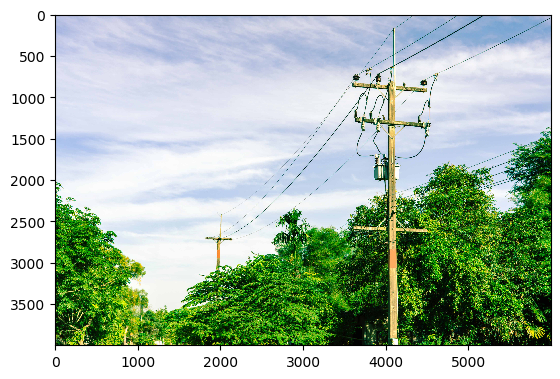

In [38]:
plt.imshow(input_image)

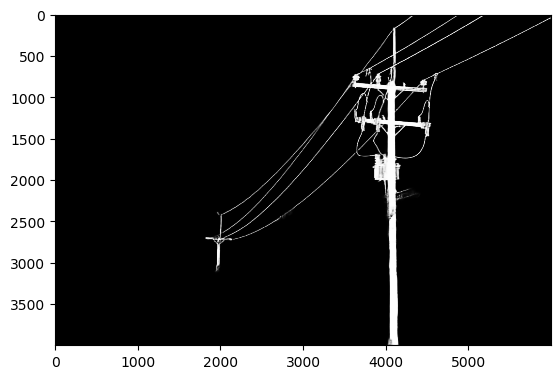

In [39]:
plt.imshow(payload, cmap='gray')

In [ ]:
## Save output mask as png
from skimage import io
io.imsave(os.path.join("output/mask.png"),payload)

## 4. Clean up

Delete async endpoint

In [ ]:
sm_client.delete_endpoint(EndpointName=endpoint_name)